In [15]:
import numpy as np
from enum import Enum
from typing import Tuple
from collections import namedtuple
from abc import ABC, abstractmethod

In [16]:
Rewards = namedtuple('Rewards', ['value', 'optimal'])
PROBLEMS = 100
class TestbedType(Enum):
    STATIONARY = 0
    NON_STATIONARY = 1

class Testbed():
    def __init__(self, testbedType: TestbedType = TestbedType.STATIONARY, offset:int = 0, problems: int = PROBLEMS, arms: int = 10):
        self._type=testbedType
        self._offset=offset
        self._q = np.random.normal(offset, 1, (problems, arms))
        self._optimals = np.argmax(self._q, axis=1)

    def get_rewards(self, action: np.array) -> Rewards:
        # use property of normal distribution here: N(a, 1) = a + N(0, 1)
        reward_constant = np.take_along_axis(self._q, action[:, None], axis=1).flatten()
        reward_noise = np.random.normal(0, 1, action.shape[0])
        final_reward = reward_constant + reward_noise
        
        ret = Rewards(value=final_reward, optimal=self._optimals)
        if (self._type == TestbedType.NON_STATIONARY):
            self._q += np.random.normal(0, 0.01, self._q.shape)
            self._optimals = np.argmax(self._q, axis=1)

        return ret


In [17]:
class Agent(ABC):
    def __init__(self, time:int):
        self._average_reward=np.zeros(time)
        self._percent_optimal=np.zeros(time)

    @abstractmethod
    def get_next_actions(self) -> np.array:
        pass

    @abstractmethod
    def process_rewards(self, rewards: Rewards) -> None:
        pass
        
    def get_average_rewards(self) -> np.array:
        return self._average_reward

    def get_percent_optimal_actions(self) -> np.array:
        return self._percent_optimal
    

# e-Greedy Sample Average Method

In [18]:
class EGreedySampleAverage(Agent):
    def __init__(self, time:int, e: np.float64, problems: int = PROBLEMS, arms: int = 10):
        super().__init__(time)
        self._e: np.float64 = e
        self._problems: int = problems
        self._arms: int = arms
        
        self._action_counts: np.array = np.zeros((problems, arms))
        self._estimates: np.array = np.zeros((problems, arms))

        self._step = 0
        self._recieved_rewards = True

        self._current_actions: np.array = np.zeros(arms, dtype=int)
        

    def get_next_actions(self) -> np.array:
        if not self._recieved_rewards:
            return self._current_actions
        
        greedy = np.argmax(self._estimates, axis=1)
        # print("greedy action: ", greedy)
        random = np.random.randint(0, self._arms, self._problems)
        # print("random: ", random)

        # flip a biased coin for each problem, to either pick greedy (0) or random (1)
        coinflip = np.random.binomial(1, self._e, self._problems)
        # print("coinflip: ", coinflip)

        # pick outputs based on coinflip result
        self._current_actions = np.where(coinflip, random, greedy)
        
        # don't re-generate actions if no reward recieved yet
        self._recieved_rewards = False
        return self._current_actions
        
    
    def process_rewards(self, rewards: Rewards) -> None:
        self._action_counts[np.arange(self._problems), self._current_actions] += 1

        current_estimates = self._estimates[np.arange(self._problems), self._current_actions]
        current_counts = self._action_counts[np.arange(self._problems), self._current_actions]
        # Q_n+1 = Qn + 1/N*(Rn - Qn)
        self._estimates[np.arange(self._problems), self._current_actions] = \
            current_estimates + (1/current_counts) * (rewards.value - current_estimates)

        # print("estimates: ", self._estimates)

        # set averages
        self._average_reward[self._step] = np.mean(rewards.value)
        # print("average reward of this step: ", np.mean(rewards.value))
        self._percent_optimal[self._step] = np.mean(rewards.optimal == self._current_actions)
        # print("percent optimal: ", self._percent_optimal[self._step])

        self._recieved_rewards = True
        self._step += 1



        
    
        

# e-Greedy Exponentially Weighted Recency Average

In [19]:
class EGreedyExpWeight(Agent):
    def __init__(self, time:int, a: np.float64, problems: int = PROBLEMS, arms: int = 10):
        super().__init__(time)
        self._e: np.float64 = 0.1
        self._a: np.float64 = a
        self._problems: int = problems
        self._arms: int = arms
        
        self._action_counts: np.array = np.zeros((problems, arms))
        self._estimates: np.array = np.zeros((problems, arms))

        self._step = 0
        self._recieved_rewards = True

        self._current_actions: np.array = np.zeros(arms, dtype=int)


    def get_next_actions(self) -> np.array:
        if not self._recieved_rewards:
            return self._current_actions
        
        greedy = np.argmax(self._estimates, axis=1)
        # print("greedy action: ", greedy)
        random = np.random.randint(0, self._arms, self._problems)
        # print("random: ", random)

        # flip a biased coin for each problem, to either pick greedy (0) or random (1)
        coinflip = np.random.binomial(1, self._e, self._problems)
        # print("coinflip: ", coinflip)

        # pick outputs based on coinflip result
        self._current_actions = np.where(coinflip, random, greedy)
        
        # don't re-generate actions if no reward recieved yet
        self._recieved_rewards = False
        return self._current_actions
        
    
    def process_rewards(self, rewards: Rewards) -> None:
        self._action_counts[np.arange(self._problems), self._current_actions] += 1

        current_estimates = self._estimates[np.arange(self._problems), self._current_actions]
        current_counts = self._action_counts[np.arange(self._problems), self._current_actions]
        # Q_n+1 = Qn + a*(Rn - Qn)
        self._estimates[np.arange(self._problems), self._current_actions] = \
            current_estimates + self._a * (rewards.value - current_estimates)

        # set averages
        self._average_reward[self._step] = np.mean(rewards.value)
        self._percent_optimal[self._step] = np.mean(rewards.optimal == self._current_actions)

        self._recieved_rewards = True
        self._step += 1


# Upper Confidence Bound Method

In [36]:
class UCBAgent(Agent):
    def __init__(self, time:int, c: np.float64, problems: int = PROBLEMS, arms: int = 10):
        super().__init__(time)
        self._c: np.float64 = c
        self._problems: int = problems
        self._arms: int = arms
        
        self._action_counts: np.array = np.zeros((problems, arms))
        self._estimates: np.array = np.zeros((problems, arms))

        self._step = 0
        self._recieved_rewards = True

        self._current_actions: np.array = np.zeros(arms, dtype=int)


    def get_next_actions(self) -> np.array:
        if not self._recieved_rewards:
            return self._current_actions
        
        # calculate the upper confidence bounds for each action
        bounds = self._estimates + self._c * np.sqrt(self._step / np.maximum(1, self._action_counts))
        
        # pick outputs based on coinflip result
        self._current_actions = np.argmax(bounds, axis=1)
        
        # don't re-generate actions if no reward recieved yet
        self._recieved_rewards = False
        return self._current_actions
        
    
    def process_rewards(self, rewards: Rewards) -> None:
        self._action_counts[np.arange(self._problems), self._current_actions] += 1

        current_estimates = self._estimates[np.arange(self._problems), self._current_actions]
        current_counts = self._action_counts[np.arange(self._problems), self._current_actions]
        # Q_n+1 = Qn + (1/N)*(Rn - Qn)
        self._estimates[np.arange(self._problems), self._current_actions] = \
            current_estimates + (1/current_counts) * (rewards.value - current_estimates)

        # set averages
        self._average_reward[self._step] = np.mean(rewards.value)
        self._percent_optimal[self._step] = np.mean(rewards.optimal == self._current_actions)

        self._recieved_rewards = True
        self._step += 1


# Gradient Bandit Method

In [97]:
class GradientAgent(Agent):
    def __init__(self, time:int, a: np.float64, problems: int = PROBLEMS, arms: int = 10):
        super().__init__(time)
        self._a: np.float64 = a
        self._problems: int = problems
        self._arms: int = arms
        
        self._baselines: np.array = np.ones(problems)
        self._likelihoods: np.array = np.zeros((problems, arms))
        self._probabilities: np.array = np.zeros((problems, arms))

        self._step = 0
        self._recieved_rewards = True

        self._current_actions: np.array = np.zeros(arms, dtype=int)


    def get_next_actions(self) -> np.array:
        if not self._recieved_rewards:
            return self._current_actions
        
        # probabilities are the softmax of the likelihood
        self._probabilities = scipy.special.softmax(self._likelihoods, axis=1)
        
        # pick outputs based on coinflip result
        self._current_actions = np.argmax(self._probabilities, axis=1)
        
        # don't re-generate actions if no reward recieved yet
        self._recieved_rewards = False
        return self._current_actions
        
    
    def process_rewards(self, rewards: Rewards) -> None:
        baseline_diffs = rewards.value - self._baselines
        baseline_diffs = baseline_diffs[:,None]
        
        # store a copy of the current action likelihoods for a later update.
        current_likelihoods = self._likelihoods[np.arange(self._problems), self._current_actions]

        # for all actions, H(a) = H(a) - a(Rt-baseline)*pi(a)
        self._likelihoods = self._likelihoods - self._a * baseline_diffs * self._probabilities


        # for the current actions, H(At) = H(At) + a(Rt-baseline)(1-pi(At)) -> overwrite the previous update
        update = self._a * baseline_diffs.flatten() * (1 - self._probabilities[np.arange(self._problems), self._current_actions])
        self._likelihoods[np.arange(self._problems), self._current_actions] = current_likelihoods + update


        
        # Q_n+1 = Qn + (1/N)*(Rn - Qn)
        self._baselines = self._baselines + (1/max(1, self._step)) * (rewards.value - self._baselines)

        # set averages
        self._average_reward[self._step] = np.mean(rewards.value)
        self._percent_optimal[self._step] = np.mean(rewards.optimal == self._current_actions)

        self._recieved_rewards = True
        self._step += 1


# Run the Stationary testbed with all agents

In [143]:
%%time
TIMESTEPS: int = 20000
es = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]

agents_by_algo = {
    "e-Greedy Sample Average" : [EGreedySampleAverage(time=TIMESTEPS, e=np.float64(ee)) for ee in es],
    "e-Greedy Exp. Weighted" : [EGreedyExpWeight(time=TIMESTEPS, a=np.float64(ee)) for ee in es],
    "Upper Confidence Bound" : [UCBAgent(time=TIMESTEPS, c=np.float64(ee)) for ee in es],
    "Gradient": [GradientAgent(time=TIMESTEPS, a=np.float64(ee)) for ee in es]
}

testbed = Testbed(TestbedType.STATIONARY)

for i in range(TIMESTEPS):
    for algo, agents in agents_by_algo.items():
        for agent in agents:
            actions = agent.get_next_actions()
            #print(actions)
            rewards = testbed.get_rewards(actions)
            # print(rewards)
            agent.process_rewards(rewards)
        
    

CPU times: user 18.8 s, sys: 818 μs, total: 18.8 s
Wall time: 18.8 s


# Plot the parameter study - Stationary Testbed

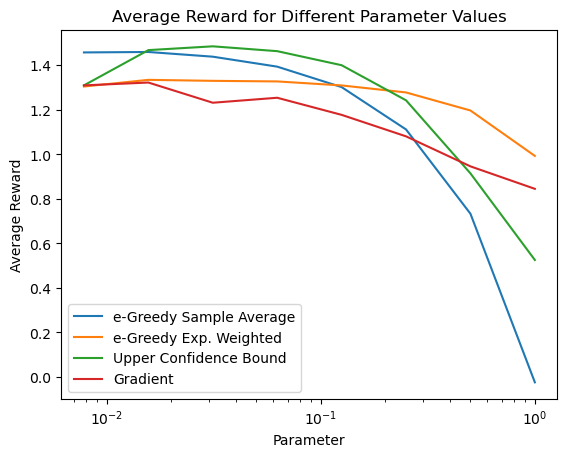

In [144]:
import matplotlib.pyplot as plt
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']


# Plot average reward for each epsilon
for algo, agents in agents_by_algo.items():

    # calculate average reward for the second half of the timesteps (ignores the initial learning portion)
    rewards = [np.mean(agent.get_average_rewards()[len(agent.get_average_rewards())//2:]) for agent in agents]
    
    plt.plot(es, rewards, label=algo)


# Add labels and title
plt.xlabel('Parameter')
plt.xscale('log')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Parameter Values')
plt.legend()

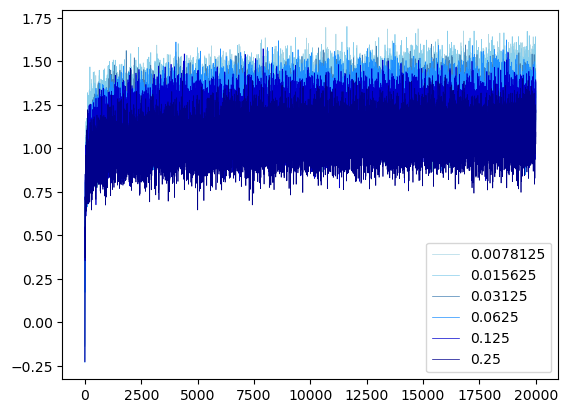

In [145]:
# Plot average reward for each epsilon

colors = ['#ADD8E6',  # Light Blue
          '#87CEEB',  # Sky Blue
          '#4682B4',  # Steel Blue
          '#1E90FF',  # Dodger Blue
          '#0000CD',  # Medium Blue
          '#00008B']  # Dark Blue

for agent, color in zip(agents_by_algo["Gradient"], colors):
    plt.plot(agent.get_average_rewards(), label=agent._a, color=color, linewidth=0.5)

plt.legend()

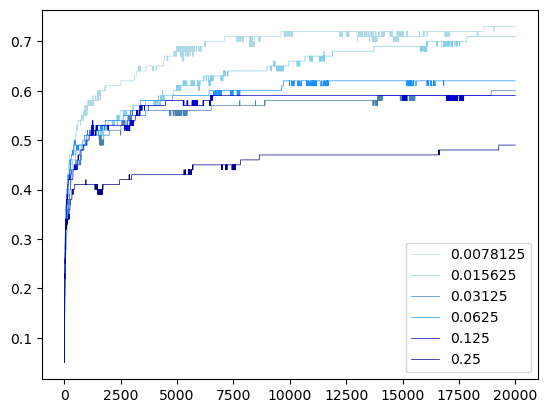

In [150]:
# Plot percent optimal action for each agent

colors = ['#ADD8E6',  # Light Blue
          '#87CEEB',  # Sky Blue
          '#4682B4',  # Steel Blue
          '#1E90FF',  # Dodger Blue
          '#0000CD',  # Medium Blue
          '#00008B']  # Dark Blue

for agent, color in zip(agents_by_algo["Gradient"], colors):
    plt.plot(agent.get_percent_optimal_actions(), label=agent._a, color=color, linewidth=0.5)

plt.legend()